In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

In [1]:
from kaggle.competitions import twosigmanews

env = twosigmanews.make_env()
print('done')

Loading the data... This could take a minute.
Done!
done


In [2]:
(market, news) = env.get_training_data()
# market_train, news_train = market_train_df.copy(), news_train_df.copy()
# market_train_df1, news_train_df1 = market_train_df.copy(), news_train_df.copy()

## Inspect market data

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
%matplotlib inline
import seaborn as sns
import numpy as np


Text(0.5,1,'total missing value for each column')

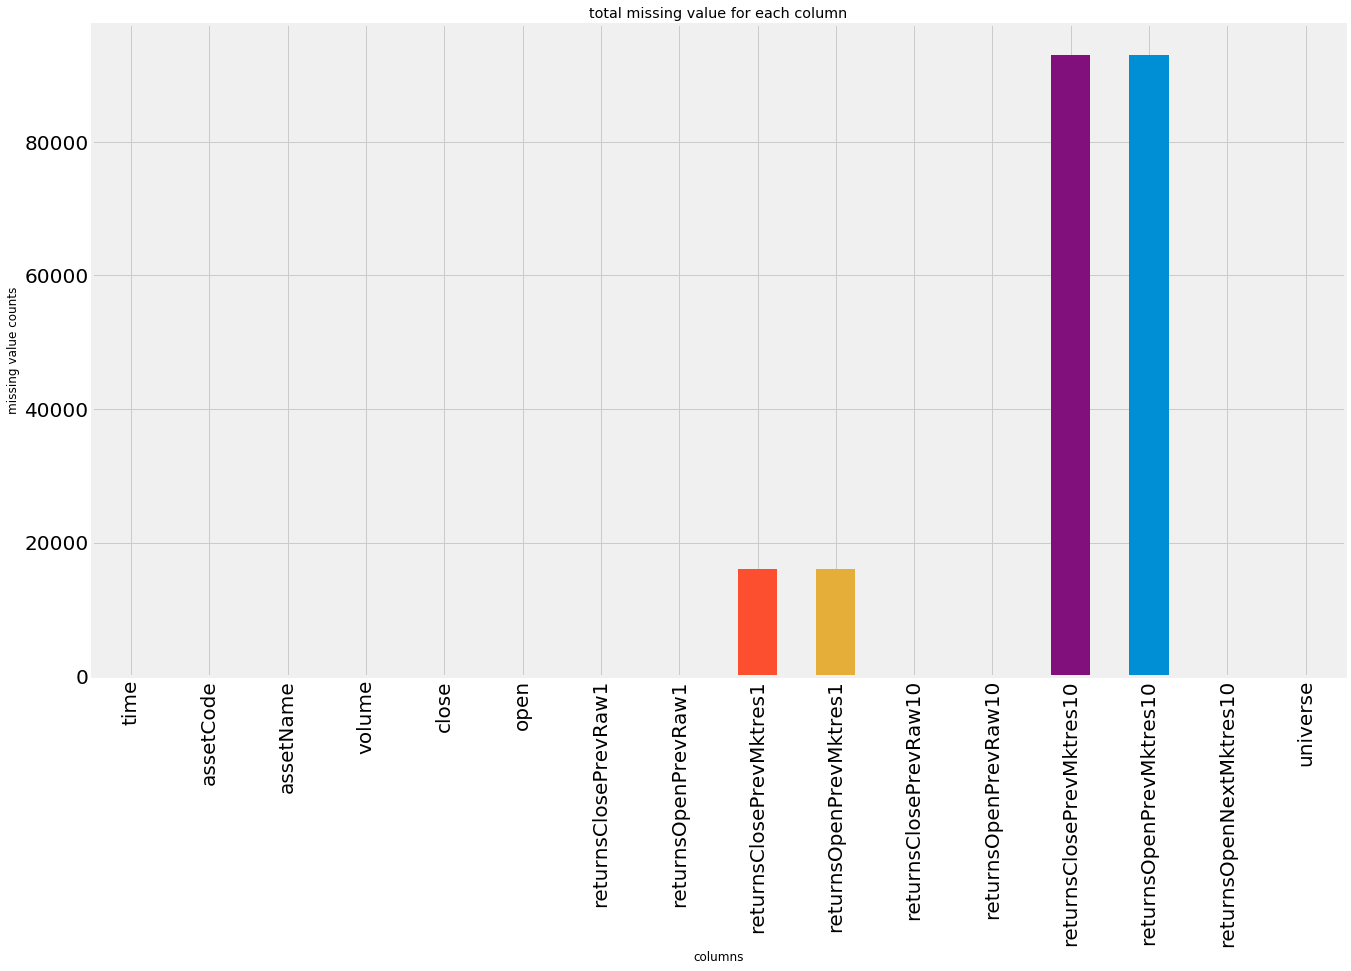

In [4]:
market.isnull().sum().plot('bar',figsize = (20,12),fontsize = 20)
plt.xlabel('columns')
plt.ylabel('missing value counts')
plt.title('total missing value for each column')


## Inpute other to object data and mean for continuous data

In [5]:
def impute(data):
    for i in data.columns:
        if data[i].dtype =='object':
            data[i] = data [i].fillna('other')
        elif (data[i].dtype=='int64' or data[i].dtype=='float64'):
            data[i] = data[i].fillna(data[i].mean())
        else:
            pass
    return data

In [6]:
market = impute(market)

## Inspect news data

Text(0.5,1,'total missing value for each column')

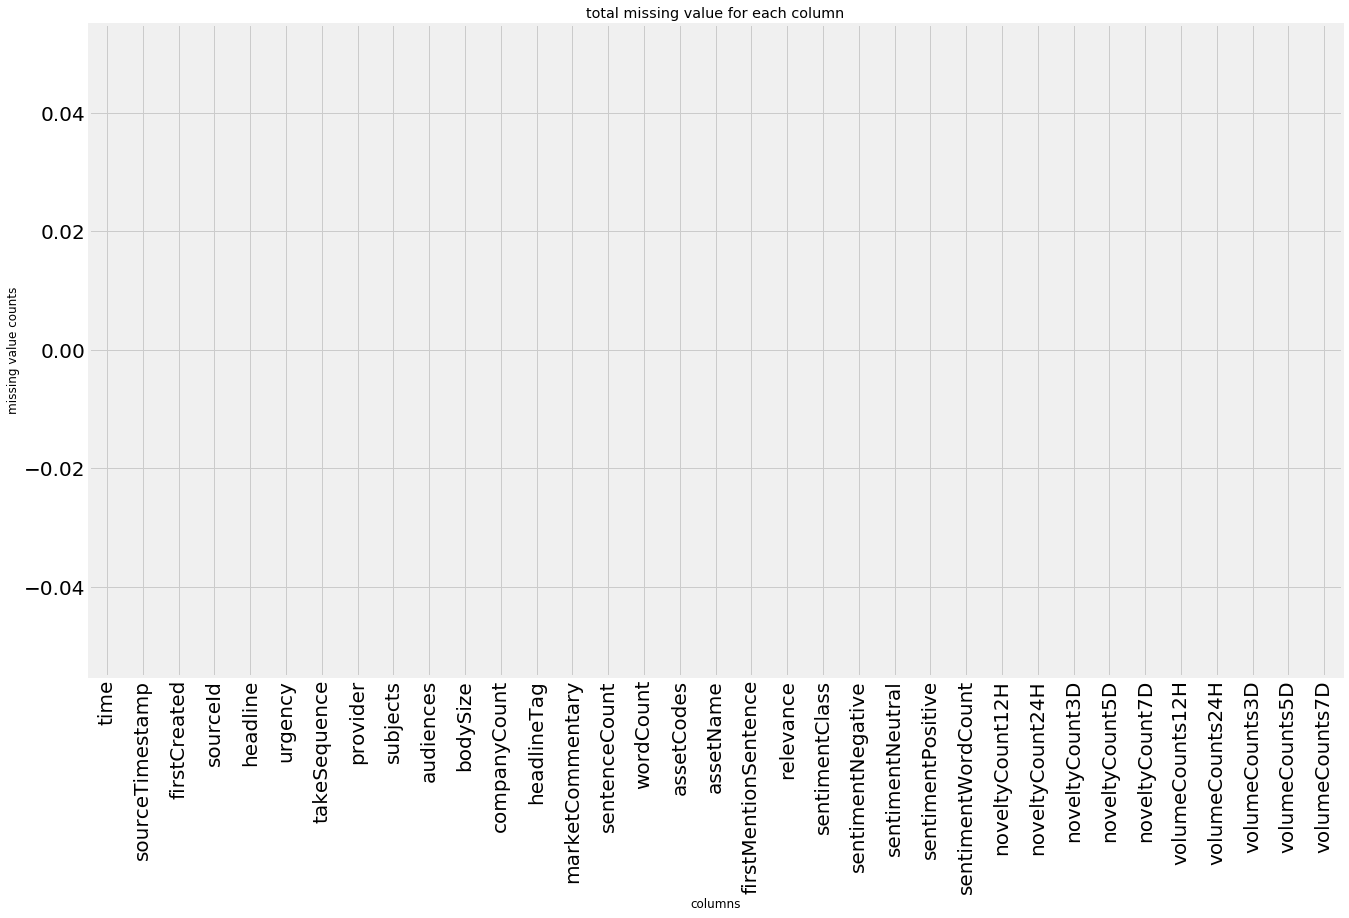

In [7]:
news.isnull().sum().plot('bar',figsize = (20,12),fontsize = 20)
plt.xlabel('columns')
plt.ylabel('missing value counts')
plt.title('total missing value for each column')


## feature engineering

In [8]:
# https://www.kaggle.com/artgor/eda-feature-engineering-and-everything
def data_prep(mdf,ndf):
    mdf['time'] = mdf.time.dt.date
    mdf['returnsOpenPrevRaw1_to_volume'] = \
    mdf['returnsOpenPrevRaw1'] / mdf['volume']
    mdf['close_to_open'] = mdf['close']/mdf['open']
    mdf['volume_to_mean'] = mdf['volume']/mdf['volume'].mean()

    ndf['sentence_word_count'] = ndf['wordCount']/ndf['sentenceCount']
    ndf['time'] = ndf.time.dt.hour
    ndf['firstCreated'] = ndf.firstCreated.dt.date
    ndf['sourceTimestamp'] = ndf.sourceTimestamp.dt.hour
    ndf['assetCodesLen'] = ndf['assetCodes'].map(lambda x: len(eval(x)))
    ndf['assetCodes'] = ndf['assetCodes'].map(lambda x: list(eval(x))[0])
    ndf['headlineLen'] = ndf['headline'].apply(lambda x: len(x))
    ndf['assetCodesLen'] = ndf['assetCodes'].apply(lambda x: len(x))
    ndf['asset_sentiment_count'] = ndf.groupby(['assetName','sentimentClass'])['time'].\
    transform('count')
    ndf['asset_sentence_mean'] = ndf.groupby(['assetName','sentenceCount'])['time'].\
    transform('mean')
    lbl = {k:v for v,k in enumerate(ndf['headlineTag'].unique())}
    ndf['headlineTagT'] = ndf['headlineTag'].map(lbl)
    kcol = ['firstCreated','assetCodes']
    ndf = ndf.groupby(kcol,as_index = False).mean()
    mdf = pd.merge(mdf,ndf,how='left',
                  left_on = ['time','assetCode'],
                  right_on = ['firstCreated','assetCodes'])

    lbl = {k: v for v, k in enumerate(mdf['assetCode'].unique())}
    mdf['assetCodeT'] = mdf['assetCode'].map(lbl)
    mdf = mdf.dropna(axis=0)
    return mdf

In [9]:
market= data_prep(market,news)

In [10]:
print(market.shape)

(822527, 54)


In [11]:
# create response variable which is to 
# predict the trending(up or down)
up = market.returnsOpenNextMktres10 >=0


In [12]:
# select features
fcol = [c for c in market.columns if c not in ['assetCode',
                                            'assetCodes',
                                            'assetCodesLen',
                                            'assetName',
                                            'assetCodeT',
                                            'headline',
                                            'headlineTag',
                                            'marketCommentaty',
                                            'provider',
                                            'returnsOpenNextMktres10',
                                            'sourceId',
                                            'subjects',
                                            'time',
                                            'time_x',
                                            'universe',
                                            'sourceTimestamp']]

X = market[fcol].values
up = up.values
r = market.returnsOpenNextMktres10.values


In [13]:
# standardization of X values
mins = np.min(X, axis=0)
maxs = np.max(X, axis=0)
rng = maxs - mins
X = 1 - ((maxs - X) / rng)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in subtract
  """
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in true_divide
  """


In [14]:
from sklearn.model_selection import train_test_split
X_train, X_test,up_train,up_test,r_train,r_test = train_test_split(X,up,r, test_size = 0.1,
                                 random_state = 42)

## Modeling

### Using Lightgbm


In [15]:
import lightgbm as lgb
lgb_train = lgb.Dataset(X_train, label = up_train)
lgb_eval = lgb.Dataset(X_test,label = up_test,
                      reference = lgb_train)

params = {'learning_rate': 0.01, 'max_depth': 12, 'boosting': 'gbdt', 'objective': 'binary', 'metric': 'auc', 'is_training_metric': True, 'seed': 42}

model = lgb.train(params,
                  lgb_train,
                  num_boost_round = 2000,
                  valid_sets = [lgb_train,lgb_eval],
                  verbose_eval = 100,
                  early_stopping_rounds = 100)

Training until validation scores don't improve for 100 rounds.
[100]	training's auc: 0.573479	valid_1's auc: 0.569375
[200]	training's auc: 0.580074	valid_1's auc: 0.575574
[300]	training's auc: 0.586618	valid_1's auc: 0.581523
[400]	training's auc: 0.593142	valid_1's auc: 0.586882
[500]	training's auc: 0.597645	valid_1's auc: 0.590396
[600]	training's auc: 0.601258	valid_1's auc: 0.592885
[700]	training's auc: 0.604439	valid_1's auc: 0.594941
[800]	training's auc: 0.60715	valid_1's auc: 0.596387
[900]	training's auc: 0.609519	valid_1's auc: 0.59744
[1000]	training's auc: 0.61171	valid_1's auc: 0.598336
[1100]	training's auc: 0.614052	valid_1's auc: 0.599314
[1200]	training's auc: 0.61652	valid_1's auc: 0.600387
[1300]	training's auc: 0.618692	valid_1's auc: 0.601269
[1400]	training's auc: 0.620898	valid_1's auc: 0.602234
[1500]	training's auc: 0.623075	valid_1's auc: 0.603212
[1600]	training's auc: 0.625053	valid_1's auc: 0.604027
[1700]	training's auc: 0.626877	valid_1's auc: 0.60471

## plot feature importance returned by lgb model

In [16]:
def generate_color():
    color = '#{:02x}{:02x}{:02x}'.format(
    *map(lambda x: np.random.randint(0,255),range(3)))
    
    return color


In [17]:
df = pd.DataFrame({'imp':model.feature_importance(),
                   'col':fcol}).sort_values(['imp'],ascending = False)
    

<BarContainer object of 20 artists>

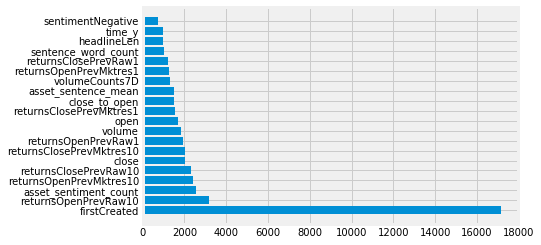

In [18]:
plt.barh(df.col[:20],df.imp[:20])

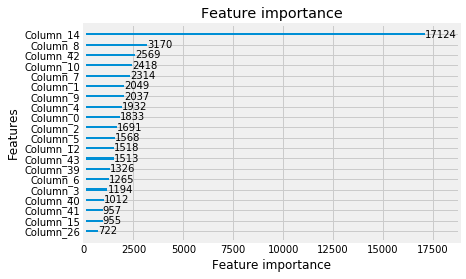

In [19]:
ax = lgb.plot_importance(model,max_num_features = 20)
plt.show()

## Make Predictions

In [ ]:
days = env.get_prediction_days()
import time

n_days = 0
prep_time = 0
prediction_time = 0
packaging_time = 0
for (market_obs_df, news_obs_df, predictions_template_df) in days:
    n_days +=1
    if n_days % 50 == 0:
        print(n_days,end=' ')
    
    t = time.time()
    market_obs_df = data_prep(market_obs_df, news_obs_df)
    market_obs_df = market_obs_df[market_obs_df.assetCode.isin(predictions_template_df.assetCode)]
    X_live = market_obs_df[fcol].values
    X_live = 1 - ((maxs - X_live) / rng)
    prep_time += time.time() - t
    
    t = time.time()
    lp = model.predict(X_live)
    prediction_time += time.time() -t
    
    t = time.time()
    confidence = 2 * lp -1
    preds = pd.DataFrame({'assetCode':market_obs_df['assetCode'],'confidence':confidence})
    predictions_template_df = predictions_template_df.merge(preds,how='left').drop('confidenceValue',axis=1).fillna(0).rename(columns={'confidence':'confidenceValue'})
    env.predict(predictions_template_df)
    packaging_time += time.time() - t
    
env.write_submission_file()